# Diamonds
---

Import libraries

In [50]:
import duckdb
import pandas as pd
import numpy as np
import sys
import re
sys.path.insert(0, "../modules")
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
cf.go_offline()
import matplotlib.pyplot as plt
import seaborn as sns

Add the functions

In [2]:

def row_filter(df, cat_var, cat_values):
    df = df[df[cat_var].isin([cat_values])].sort_values(by='price', ascending=False)
    return df.reset_index(drop=True)

def nrow_filter(df, cat_var, cat_values):
    df = df[~df[cat_var].isin([cat_values])].sort_values(by='price', ascending=False)
    return df.reset_index(drop=True)

def groupby_sum(df, group_vars, agg_var='price', sort_var='price'):
    df = df.groupby(group_vars, as_index=False).agg({agg_var:'sum'})
    df = df.sort_values(by=sort_var, ascending=False)
    return df.reset_index(drop=True)

def pivot_table(df, col, x_axis, value='price'):
    df = df.pivot_table(values=value,
                        columns=col,
                        index=x_axis,
                        aggfunc='sum')
    return df.reset_index()

def groupby_median(df, group_vars, agg_var='price/carat', sort_var='price/carat'):
    df = df.groupby(group_vars, as_index=False).agg({agg_var:'median'})
    df = df.sort_values(by=sort_var, ascending=False)
    return df.reset_index(drop=True)

def groupby_mean(df, group_vars, agg_var='price/carat', sort_var='price/carat'):
    df = df.groupby(group_vars, as_index=False).agg({agg_var:'mean'})
    df = df.sort_values(by=sort_var, ascending=False)
    return df.reset_index(drop=True)

### Database adquisition

---

Extract tables

In [3]:
diamonds = duckdb.connect('./diamonds_train.db')
diamonds = diamonds.sql('show tables').df()

In [4]:
diamonds_describe = duckdb.connect('./diamonds_train.db')
diamonds_describe = diamonds_describe.sql('describe').df()

In [5]:
diamonds_city = duckdb.connect('./diamonds_train.db')
diamonds_city = diamonds_city.sql('select * from diamonds_city').df()

In [6]:
diamonds_clarity = duckdb.connect('./diamonds_train.db')
diamonds_clarity = diamonds_clarity.sql('select * from diamonds_clarity').df()

In [7]:
diamonds_color = duckdb.connect('./diamonds_train.db')
diamonds_color = diamonds_color.sql('select * from diamonds_color').df()

In [8]:
diamonds_cut = duckdb.connect('./diamonds_train.db')
diamonds_cut = diamonds_cut.sql('select * from diamonds_cut').df()

In [9]:
diamonds_dimensions = duckdb.connect('./diamonds_train.db')
diamonds_dimensions = diamonds_dimensions.sql('select * from diamonds_dimensions').df()

In [10]:
diamonds_properties = duckdb.connect('./diamonds_train.db')
diamonds_properties = diamonds_properties.sql('select * from diamonds_properties').df()

In [11]:
diamonds_transactional = duckdb.connect('./diamonds_train.db')
diamonds_transactional = diamonds_transactional.sql('select * from diamonds_transactional').df()

Join tables

In [12]:
diamondsall = pd.merge(diamonds_properties,diamonds_transactional, how = 'left', on='index_id')
diamondsall = pd.merge(diamondsall,diamonds_dimensions, how = 'left', on='index_id')
diamondsall = pd.merge(diamondsall,diamonds_cut, how = 'left', on='cut_id')
diamondsall = pd.merge(diamondsall,diamonds_color, how = 'left', on='color_id')
diamondsall = pd.merge(diamondsall,diamonds_clarity, how = 'left', on='clarity_id')
diamondsall = pd.merge(diamondsall,diamonds_city, how = 'left', on='city_id')

Sort the table by price

In [13]:
diamondsall.sort_values(by ='price', ascending = False)

,index_id,cut_id,color_id,clarity_id,price,city_id,carat,depth,table,x,y,z,cut,color,clarity,city
7034,0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,18823,89c7286890f7347ab235234e74d406596a127ae3679042...,2.29,60.8,60.0,8.50,8.47,5.16,Premium,I,VS2,Kimberly
3990,ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18818,e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...,2.00,63.5,56.0,7.90,7.97,5.04,Very Good,G,SI1,Madrid
29107,8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...,18806,5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...,1.51,61.7,55.0,7.37,7.41,4.56,Ideal,G,IF,New York City
25529,57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18797,ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...,2.29,61.8,59.0,8.52,8.45,5.24,Premium,I,SI1,Surat
618,ee377871c73631fd6543ddb5164d0b48ea072daa207a91...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,18795,89c7286890f7347ab235234e74d406596a127ae3679042...,2.00,60.8,59.0,8.13,8.02,4.91,Premium,I,VS1,Kimberly
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084,5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,335,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.31,63.3,58.0,4.34,4.35,2.75,Good,J,SI2,Tel Aviv
20968,c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,334,89c7286890f7347ab235234e74d406596a127ae3679042...,0.29,62.4,58.0,4.20,4.23,2.63,Premium,I,VS2,Kimberly
18381,b3884138875a4fff84c082069e1f4adc178c3642c8b872...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,327,1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...,0.23,56.9,65.0,4.05,4.07,2.31,Good,E,VS1,Zurich
9782,257e3cd0744845b83c0d1f8a114d5c04218844a0c8debe...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,326,5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...,0.23,61.5,55.0,3.95,3.98,2.43,Ideal,E,SI2,Paris


### Delete zero values

Seek the zero values of x, y, z (I Know of method describe that there are zeros in)

In [14]:
diamondsdf_x_zero = row_filter(diamondsall, 'x', 0)
diamondsdf_x_zero

,index_id,cut_id,color_id,clarity_id,price,city_id,carat,depth,table,x,y,z,cut,color,clarity,city
0,22207e1ed25c7378b9e7a688e74ae30501008927fb4a3d...,de88c121a82a06352bf1aaceba20578356408a334ba046...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,18034,89c7286890f7347ab235234e74d406596a127ae3679042...,2.25,62.8,59.0,0.0,0.00,0.0,Premium,H,SI2,Kimberly
1,41e2e3dcdbd3996fc30e82e520b032432e1ad19ff94905...,f7b19afcde965ea4942b878d266f89f8ba9a5a833e60f7...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,6381,ca3aa21a5b70c3e88cc6336682c8c7da928a0c66a5ead4...,1.14,57.5,67.0,0.0,0.00,0.0,Fair,G,VS1,Antwerp
2,2659730a46782b733d4e18192e92a17ee69b2eaa7538e2...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,f67ab10ad4e4c53121b6a5fe4da9c10ddee905b978d378...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,4954,89c7286890f7347ab235234e74d406596a127ae3679042...,1.07,61.6,56.0,0.0,6.62,0.0,Ideal,F,SI2,Kimberly
3,0c73ebfedfb4af1e074a8cc2e9c530a9ae8fbc79eae5b5...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,f67ab10ad4e4c53121b6a5fe4da9c10ddee905b978d378...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,2130,e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...,0.71,64.1,60.0,0.0,0.00,0.0,Good,F,SI2,Madrid
4,28c9bf14357dedfba260e2b4052cae63dcede2c4ff513b...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,f67ab10ad4e4c53121b6a5fe4da9c10ddee905b978d378...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,2130,89c7286890f7347ab235234e74d406596a127ae3679042...,0.71,64.1,60.0,0.0,0.00,0.0,Good,F,SI2,Kimberly


In [15]:
diamondsdf_y_zero = row_filter(diamondsall, 'y', 0)
diamondsdf_y_zero

,index_id,cut_id,color_id,clarity_id,price,city_id,carat,depth,table,x,y,z,cut,color,clarity,city
0,22207e1ed25c7378b9e7a688e74ae30501008927fb4a3d...,de88c121a82a06352bf1aaceba20578356408a334ba046...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,18034,89c7286890f7347ab235234e74d406596a127ae3679042...,2.25,62.8,59.0,0.0,0.0,0.0,Premium,H,SI2,Kimberly
1,41e2e3dcdbd3996fc30e82e520b032432e1ad19ff94905...,f7b19afcde965ea4942b878d266f89f8ba9a5a833e60f7...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,6381,ca3aa21a5b70c3e88cc6336682c8c7da928a0c66a5ead4...,1.14,57.5,67.0,0.0,0.0,0.0,Fair,G,VS1,Antwerp
2,0c73ebfedfb4af1e074a8cc2e9c530a9ae8fbc79eae5b5...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,f67ab10ad4e4c53121b6a5fe4da9c10ddee905b978d378...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,2130,e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...,0.71,64.1,60.0,0.0,0.0,0.0,Good,F,SI2,Madrid
3,28c9bf14357dedfba260e2b4052cae63dcede2c4ff513b...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,f67ab10ad4e4c53121b6a5fe4da9c10ddee905b978d378...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,2130,89c7286890f7347ab235234e74d406596a127ae3679042...,0.71,64.1,60.0,0.0,0.0,0.0,Good,F,SI2,Kimberly


In [16]:
diamondsdf_z_zero = row_filter(diamondsall, 'z', 0)
diamondsdf_z_zero

,index_id,cut_id,color_id,clarity_id,price,city_id,carat,depth,table,x,y,z,cut,color,clarity,city
0,c279a17c96f126fc4784ddecd87267c9b8dfc9ed047d4b...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,18788,89c7286890f7347ab235234e74d406596a127ae3679042...,2.80,63.8,58.0,8.90,8.85,0.0,Good,G,SI2,Kimberly
1,5366ec7df49331f43da1f43fedc75ce2b333ccc2b39fd9...,de88c121a82a06352bf1aaceba20578356408a334ba046...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,18207,e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...,2.02,62.7,53.0,8.02,7.95,0.0,Premium,H,VS2,Madrid
2,22207e1ed25c7378b9e7a688e74ae30501008927fb4a3d...,de88c121a82a06352bf1aaceba20578356408a334ba046...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,18034,89c7286890f7347ab235234e74d406596a127ae3679042...,2.25,62.8,59.0,0.00,0.00,0.0,Premium,H,SI2,Kimberly
3,3366cbd949ed025b9bb9a706f82eb6d53993c012e64360...,de88c121a82a06352bf1aaceba20578356408a334ba046...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,17265,ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...,2.20,61.2,59.0,8.42,8.37,0.0,Premium,H,SI1,Surat
4,e832a0253523f9e2e4a0a7bb28f4bf44eb0ca8c38eab12...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,15397,5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...,2.25,61.3,58.0,8.52,8.42,0.0,Premium,I,SI1,Paris
5,105a4d48d04d0d1f1c95676eacd8442d4d2611eab8a107...,de88c121a82a06352bf1aaceba20578356408a334ba046...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,12631,ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...,2.18,59.4,61.0,8.49,8.45,0.0,Premium,H,SI2,Surat
6,41e2e3dcdbd3996fc30e82e520b032432e1ad19ff94905...,f7b19afcde965ea4942b878d266f89f8ba9a5a833e60f7...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,6381,ca3aa21a5b70c3e88cc6336682c8c7da928a0c66a5ead4...,1.14,57.5,67.0,0.00,0.00,0.0,Fair,G,VS1,Antwerp
7,fa0cb0b93e1bdf27a23aaf0d8f7a775ec055dd432cc8c6...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,5564,5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...,1.15,59.2,56.0,6.88,6.83,0.0,Ideal,G,VS2,New York City
8,2659730a46782b733d4e18192e92a17ee69b2eaa7538e2...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,f67ab10ad4e4c53121b6a5fe4da9c10ddee905b978d378...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,4954,89c7286890f7347ab235234e74d406596a127ae3679042...,1.07,61.6,56.0,0.00,6.62,0.0,Ideal,F,SI2,Kimberly
9,236a75b2ceb98dd392c779cb72c89460f5788d35f9e843...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...,4731,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,1.50,64.0,61.0,7.15,7.04,0.0,Good,G,I1,Tel Aviv


In [17]:
diamondsall = diamondsall.loc[diamondsall['z'] > 0].sort_values(by ='y', ascending = False)
diamondsall

,index_id,cut_id,color_id,clarity_id,price,city_id,carat,depth,table,x,y,z,cut,color,clarity,city
14708,daeb96ce8d169c2a9b958853c724d46352d4749b0ebffa...,de88c121a82a06352bf1aaceba20578356408a334ba046...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,12210,5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...,2.00,58.9,57.0,8.09,58.90,8.06,Premium,H,SI2,Paris
31083,0f1f13ef2ed5183e68c29c8c99f19851b2fc0f226c385d...,f7b19afcde965ea4942b878d266f89f8ba9a5a833e60f7...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...,18531,6c425048aa7badd9d84615bd8620ca1864efd81cfdb69d...,4.50,65.8,58.0,10.23,10.16,6.72,Fair,J,I1,Dubai
3468,11f4138f4d6ee3c5d5b803a8010f59d227a51fbb2c33f3...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...,15223,ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...,4.01,61.0,61.0,10.14,10.10,6.17,Premium,I,I1,Surat
2884,8835f492a7c86f65d900be580894bbc8f8becf17daa5c2...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...,15984,5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...,4.00,63.3,58.0,10.01,9.94,6.31,Very Good,I,I1,New York City
23609,97eae470fe88a1530036f6f95ccb15c9d486a2fc8de1ad...,de88c121a82a06352bf1aaceba20578356408a334ba046...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...,15223,5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...,4.01,62.5,62.0,10.02,9.94,6.24,Premium,J,I1,Paris
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8984,946b10af6556fa2a80dec60473a6a50d37971009002005...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,386,0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...,0.21,63.2,54.0,3.82,3.78,2.40,Very Good,E,VS2,Amsterdam
6423,95d3a6437b56fbcc23f34db6b519c4956c53e2955c76a9...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,367,ed76f191621cf6ed77eab6a8013d1cb4bdfa89a75a24aa...,0.20,59.8,62.0,3.79,3.77,2.26,Premium,E,VS2,Luxembourg
23007,927fcdcd5c55b3c3cd828fa8e5d5ce7af4e9096d4b9a0b...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,367,89c7286890f7347ab235234e74d406596a127ae3679042...,0.20,61.5,57.0,3.81,3.77,2.33,Ideal,D,VS2,Kimberly
1582,6d78b19a042a64f08cc4df0d42fb91cd757829718e60e8...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,345,ca3aa21a5b70c3e88cc6336682c8c7da928a0c66a5ead4...,0.20,60.2,62.0,3.79,3.75,2.27,Premium,E,SI2,Antwerp


# Add bins for statistics

Create the function


In [18]:
def price_div(price, div):
    if div == 0:
        return 0
    else:
        return price/div
    
    
def multiply_divide(uno, dos, tres, cuatro):
    resultado = uno * dos * tres / cuatro
    return resultado

In [ ]:
def angulo(table raiz cuadrada o %, z (alto), x o y):
    angulo = 

### Bin xyz / depth

In [19]:
diamondsall['xyz/depth'] = diamondsall.apply(lambda x : multiply_divide(x['x'], x['y'], x['z'], x['depth']), axis=1)
diamondsall

,index_id,cut_id,color_id,clarity_id,price,city_id,carat,depth,table,x,y,z,cut,color,clarity,city,xyz/depth
14708,daeb96ce8d169c2a9b958853c724d46352d4749b0ebffa...,de88c121a82a06352bf1aaceba20578356408a334ba046...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,12210,5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...,2.00,58.9,57.0,8.09,58.90,8.06,Premium,H,SI2,Paris,65.205400
31083,0f1f13ef2ed5183e68c29c8c99f19851b2fc0f226c385d...,f7b19afcde965ea4942b878d266f89f8ba9a5a833e60f7...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...,18531,6c425048aa7badd9d84615bd8620ca1864efd81cfdb69d...,4.50,65.8,58.0,10.23,10.16,6.72,Fair,J,I1,Dubai,10.614822
3468,11f4138f4d6ee3c5d5b803a8010f59d227a51fbb2c33f3...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...,15223,ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...,4.01,61.0,61.0,10.14,10.10,6.17,Premium,I,I1,Surat,10.358924
2884,8835f492a7c86f65d900be580894bbc8f8becf17daa5c2...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...,15984,5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...,4.00,63.3,58.0,10.01,9.94,6.31,Very Good,I,I1,New York City,9.918503
23609,97eae470fe88a1530036f6f95ccb15c9d486a2fc8de1ad...,de88c121a82a06352bf1aaceba20578356408a334ba046...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...,15223,5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...,4.01,62.5,62.0,10.02,9.94,6.24,Premium,J,I1,Paris,9.943944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8984,946b10af6556fa2a80dec60473a6a50d37971009002005...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,386,0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...,0.21,63.2,54.0,3.82,3.78,2.40,Very Good,E,VS2,Amsterdam,0.548339
6423,95d3a6437b56fbcc23f34db6b519c4956c53e2955c76a9...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,367,ed76f191621cf6ed77eab6a8013d1cb4bdfa89a75a24aa...,0.20,59.8,62.0,3.79,3.77,2.26,Premium,E,VS2,Luxembourg,0.539993
23007,927fcdcd5c55b3c3cd828fa8e5d5ce7af4e9096d4b9a0b...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,367,89c7286890f7347ab235234e74d406596a127ae3679042...,0.20,61.5,57.0,3.81,3.77,2.33,Ideal,D,VS2,Kimberly,0.544186
1582,6d78b19a042a64f08cc4df0d42fb91cd757829718e60e8...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,345,ca3aa21a5b70c3e88cc6336682c8c7da928a0c66a5ead4...,0.20,60.2,62.0,3.79,3.75,2.27,Premium,E,SI2,Antwerp,0.535920


### Bin xyz/table

In [20]:
diamondsall['xyz/table'] = diamondsall.apply(lambda x : multiply_divide(x['x'], x['y'], x['z'], x['table']), axis=1)
diamondsall

,index_id,cut_id,color_id,clarity_id,price,city_id,carat,depth,table,x,y,z,cut,color,clarity,city,xyz/depth,xyz/table
14708,daeb96ce8d169c2a9b958853c724d46352d4749b0ebffa...,de88c121a82a06352bf1aaceba20578356408a334ba046...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,12210,5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...,2.00,58.9,57.0,8.09,58.90,8.06,Premium,H,SI2,Paris,65.205400,67.378913
31083,0f1f13ef2ed5183e68c29c8c99f19851b2fc0f226c385d...,f7b19afcde965ea4942b878d266f89f8ba9a5a833e60f7...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...,18531,6c425048aa7badd9d84615bd8620ca1864efd81cfdb69d...,4.50,65.8,58.0,10.23,10.16,6.72,Fair,J,I1,Dubai,10.614822,12.042333
3468,11f4138f4d6ee3c5d5b803a8010f59d227a51fbb2c33f3...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...,15223,ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...,4.01,61.0,61.0,10.14,10.10,6.17,Premium,I,I1,Surat,10.358924,10.358924
2884,8835f492a7c86f65d900be580894bbc8f8becf17daa5c2...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...,15984,5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...,4.00,63.3,58.0,10.01,9.94,6.31,Very Good,I,I1,New York City,9.918503,10.824849
23609,97eae470fe88a1530036f6f95ccb15c9d486a2fc8de1ad...,de88c121a82a06352bf1aaceba20578356408a334ba046...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...,15223,5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...,4.01,62.5,62.0,10.02,9.94,6.24,Premium,J,I1,Paris,9.943944,10.024137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8984,946b10af6556fa2a80dec60473a6a50d37971009002005...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,386,0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...,0.21,63.2,54.0,3.82,3.78,2.40,Very Good,E,VS2,Amsterdam,0.548339,0.641760
6423,95d3a6437b56fbcc23f34db6b519c4956c53e2955c76a9...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,367,ed76f191621cf6ed77eab6a8013d1cb4bdfa89a75a24aa...,0.20,59.8,62.0,3.79,3.77,2.26,Premium,E,VS2,Luxembourg,0.539993,0.520832
23007,927fcdcd5c55b3c3cd828fa8e5d5ce7af4e9096d4b9a0b...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,367,89c7286890f7347ab235234e74d406596a127ae3679042...,0.20,61.5,57.0,3.81,3.77,2.33,Ideal,D,VS2,Kimberly,0.544186,0.587148
1582,6d78b19a042a64f08cc4df0d42fb91cd757829718e60e8...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,345,ca3aa21a5b70c3e88cc6336682c8c7da928a0c66a5ead4...,0.20,60.2,62.0,3.79,3.75,2.27,Premium,E,SI2,Antwerp,0.535920,0.520361


### Bin of xyz/carat

In [21]:
diamondsall['xyz/carat'] = diamondsall.apply(lambda x : multiply_divide(x['x'], x['y'], x['z'], x['carat']), axis=1)
diamondsall

,index_id,cut_id,color_id,clarity_id,price,city_id,carat,depth,table,x,y,z,cut,color,clarity,city,xyz/depth,xyz/table,xyz/carat
14708,daeb96ce8d169c2a9b958853c724d46352d4749b0ebffa...,de88c121a82a06352bf1aaceba20578356408a334ba046...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,12210,5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...,2.00,58.9,57.0,8.09,58.90,8.06,Premium,H,SI2,Paris,65.205400,67.378913,1920.299030
31083,0f1f13ef2ed5183e68c29c8c99f19851b2fc0f226c385d...,f7b19afcde965ea4942b878d266f89f8ba9a5a833e60f7...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...,18531,6c425048aa7badd9d84615bd8620ca1864efd81cfdb69d...,4.50,65.8,58.0,10.23,10.16,6.72,Fair,J,I1,Dubai,10.614822,12.042333,155.212288
3468,11f4138f4d6ee3c5d5b803a8010f59d227a51fbb2c33f3...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...,15223,ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...,4.01,61.0,61.0,10.14,10.10,6.17,Premium,I,I1,Surat,10.358924,10.358924,157.579646
2884,8835f492a7c86f65d900be580894bbc8f8becf17daa5c2...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...,15984,5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...,4.00,63.3,58.0,10.01,9.94,6.31,Very Good,I,I1,New York City,9.918503,10.824849,156.960303
23609,97eae470fe88a1530036f6f95ccb15c9d486a2fc8de1ad...,de88c121a82a06352bf1aaceba20578356408a334ba046...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...,15223,5dd272b4f316b776a7b8e3d0894b37e1e42be3d5d3b204...,4.01,62.5,62.0,10.02,9.94,6.24,Premium,J,I1,Paris,9.943944,10.024137,154.986661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8984,946b10af6556fa2a80dec60473a6a50d37971009002005...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,386,0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...,0.21,63.2,54.0,3.82,3.78,2.40,Very Good,E,VS2,Amsterdam,0.548339,0.641760,165.024000
6423,95d3a6437b56fbcc23f34db6b519c4956c53e2955c76a9...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,367,ed76f191621cf6ed77eab6a8013d1cb4bdfa89a75a24aa...,0.20,59.8,62.0,3.79,3.77,2.26,Premium,E,VS2,Luxembourg,0.539993,0.520832,161.457790
23007,927fcdcd5c55b3c3cd828fa8e5d5ce7af4e9096d4b9a0b...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,367,89c7286890f7347ab235234e74d406596a127ae3679042...,0.20,61.5,57.0,3.81,3.77,2.33,Ideal,D,VS2,Kimberly,0.544186,0.587148,167.337105
1582,6d78b19a042a64f08cc4df0d42fb91cd757829718e60e8...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,345,ca3aa21a5b70c3e88cc6336682c8c7da928a0c66a5ead4...,0.20,60.2,62.0,3.79,3.75,2.27,Premium,E,SI2,Antwerp,0.535920,0.520361,161.311875


### Bin of price/carat

In [22]:
diamondsall['price/carat'] = diamondsall.apply(lambda x : price_div(x['price'], x['carat']), axis=1)
diamondsall.sort_values(by = 'price/carat', ascending = False)

,index_id,cut_id,color_id,clarity_id,price,city_id,carat,depth,table,x,y,z,cut,color,clarity,city,xyz/depth,xyz/table,xyz/carat,price/carat
30617,4bbcec8e814749f2b038f5c0f4bfd06c039d8a510ec58f...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...,7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...,18542,0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...,1.04,61.3,56.0,6.53,6.55,4.01,Very Good,D,IF,Amsterdam,2.797940,3.062745,164.917034,17828.846154
2195,5bc05e241527d767aae5d0921978e11918f632b8cefc1d...,de88c121a82a06352bf1aaceba20578356408a334ba046...,3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...,7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...,18279,1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...,1.07,60.9,58.0,6.67,6.57,4.03,Premium,D,IF,Zurich,2.899873,3.044867,165.048838,17083.177570
19719,5f4b75634381196faf857ccc46a291a90b75e7406c66a5...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...,7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...,18114,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,1.07,60.9,58.0,6.57,6.67,4.03,Very Good,D,IF,Tel Aviv,2.899873,3.044867,165.048838,16928.971963
21405,51bc63526c24a8a11da622ceb64e6c0831fa18cbc5adbb...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...,7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...,17100,89c7286890f7347ab235234e74d406596a127ae3679042...,1.02,61.7,59.0,6.42,6.52,3.99,Very Good,D,IF,Kimberly,2.706888,2.830763,163.740212,16764.705882
2713,75ab3e0a8f99144f9c4420698980b6f76f85996b520937...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...,7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...,15928,ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...,1.00,63.3,59.0,6.33,6.37,4.02,Good,D,IF,Surat,2.560740,2.747370,162.094842,15928.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29931,6b79358b06544b0b56ae3a05e7b60b9acd2320b1074562...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,339,1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...,0.30,64.0,55.0,4.25,4.28,2.73,Good,J,SI1,Zurich,0.775917,0.902885,165.529000,1130.000000
29172,0327d5e69f5556cfbd69f4d40e05ff0ceeaa2f569c732c...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,3f39d5c348e5b79d06e842c114e6cc571583bbf44e4b0e...,c2818bc4e5ec4ae4a357a0df6fed73652e169ec676f7d4...,361,e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...,0.32,64.0,54.0,4.33,4.36,2.78,Good,D,I1,Madrid,0.820048,0.971909,164.009575,1128.125000
36959,d63d53e3d4dd0722425e374f01a9aed9c02ab2c9b336c9...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,344,ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...,0.31,62.2,54.0,4.35,4.37,2.71,Ideal,J,SI2,Surat,0.828227,0.953995,166.179823,1109.677419
12084,5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,335,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.31,63.3,58.0,4.34,4.35,2.75,Good,J,SI2,Tel Aviv,0.820178,0.895125,167.475000,1080.645161


### Bin of price/depth

In [23]:
diamondsall['price/depth'] = diamondsall.apply(lambda x : price_div(x['price'], x['depth']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

,index_id,cut_id,color_id,clarity_id,price,city_id,carat,depth,table,x,...,z,cut,color,clarity,city,xyz/depth,xyz/table,xyz/carat,price/carat,price/depth
7034,0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,18823,89c7286890f7347ab235234e74d406596a127ae3679042...,2.29,60.8,60.0,8.50,...,5.16,Premium,I,VS2,Kimberly,6.110102,6.191570,162.224541,8219.650655,309.588816
3990,ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18818,e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...,2.00,63.5,56.0,7.90,...,5.04,Very Good,G,SI1,Madrid,4.997378,5.666670,158.666760,9409.000000,296.346457
29107,8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...,18806,5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...,1.51,61.7,55.0,7.37,...,4.56,Ideal,G,IF,New York City,4.036132,4.527806,164.920101,12454.304636,304.797407
25529,57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18797,ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...,2.29,61.8,59.0,8.52,...,5.24,Premium,I,SI1,Surat,6.104346,6.394043,164.737362,8208.296943,304.158576
6912,153de641ea0557acad28b609f949ec7ad909c0168b9af1...,de88c121a82a06352bf1aaceba20578356408a334ba046...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18795,0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...,2.04,58.1,60.0,8.37,...,4.84,Premium,H,SI1,Amsterdam,5.773312,5.590490,164.426188,9213.235294,323.493976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084,5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,335,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.31,63.3,58.0,4.34,...,2.75,Good,J,SI2,Tel Aviv,0.820178,0.895125,167.475000,1080.645161,5.292259
20968,c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,334,89c7286890f7347ab235234e74d406596a127ae3679042...,0.29,62.4,58.0,4.20,...,2.63,Premium,I,VS2,Kimberly,0.748791,0.805596,161.119241,1151.724138,5.352564
18381,b3884138875a4fff84c082069e1f4adc178c3642c8b872...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,327,1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...,0.23,56.9,65.0,4.05,...,2.31,Good,E,VS1,Zurich,0.669190,0.585798,165.551674,1421.739130,5.746924
18377,a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,326,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.21,59.8,61.0,3.89,...,2.31,Premium,E,SI1,Tel Aviv,0.577021,0.565670,164.313600,1552.380952,5.451505


### Bin of price/table

In [24]:
diamondsall['price/table'] = diamondsall.apply(lambda x : price_div(x['price'], x['table']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

,index_id,cut_id,color_id,clarity_id,price,city_id,carat,depth,table,x,...,cut,color,clarity,city,xyz/depth,xyz/table,xyz/carat,price/carat,price/depth,price/table
7034,0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,18823,89c7286890f7347ab235234e74d406596a127ae3679042...,2.29,60.8,60.0,8.50,...,Premium,I,VS2,Kimberly,6.110102,6.191570,162.224541,8219.650655,309.588816,313.716667
3990,ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18818,e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...,2.00,63.5,56.0,7.90,...,Very Good,G,SI1,Madrid,4.997378,5.666670,158.666760,9409.000000,296.346457,336.035714
29107,8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...,18806,5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...,1.51,61.7,55.0,7.37,...,Ideal,G,IF,New York City,4.036132,4.527806,164.920101,12454.304636,304.797407,341.927273
25529,57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18797,ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...,2.29,61.8,59.0,8.52,...,Premium,I,SI1,Surat,6.104346,6.394043,164.737362,8208.296943,304.158576,318.593220
6912,153de641ea0557acad28b609f949ec7ad909c0168b9af1...,de88c121a82a06352bf1aaceba20578356408a334ba046...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18795,0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...,2.04,58.1,60.0,8.37,...,Premium,H,SI1,Amsterdam,5.773312,5.590490,164.426188,9213.235294,323.493976,313.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084,5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,335,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.31,63.3,58.0,4.34,...,Good,J,SI2,Tel Aviv,0.820178,0.895125,167.475000,1080.645161,5.292259,5.775862
20968,c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,334,89c7286890f7347ab235234e74d406596a127ae3679042...,0.29,62.4,58.0,4.20,...,Premium,I,VS2,Kimberly,0.748791,0.805596,161.119241,1151.724138,5.352564,5.758621
18381,b3884138875a4fff84c082069e1f4adc178c3642c8b872...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,327,1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...,0.23,56.9,65.0,4.05,...,Good,E,VS1,Zurich,0.669190,0.585798,165.551674,1421.739130,5.746924,5.030769
18377,a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,326,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.21,59.8,61.0,3.89,...,Premium,E,SI1,Tel Aviv,0.577021,0.565670,164.313600,1552.380952,5.451505,5.344262


### Bin of price/x

In [25]:
diamondsall['price/x'] = diamondsall.apply(lambda x : price_div(x['price'], x['x']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

,index_id,cut_id,color_id,clarity_id,price,city_id,carat,depth,table,x,...,color,clarity,city,xyz/depth,xyz/table,xyz/carat,price/carat,price/depth,price/table,price/x
7034,0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,18823,89c7286890f7347ab235234e74d406596a127ae3679042...,2.29,60.8,60.0,8.50,...,I,VS2,Kimberly,6.110102,6.191570,162.224541,8219.650655,309.588816,313.716667,2214.470588
3990,ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18818,e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...,2.00,63.5,56.0,7.90,...,G,SI1,Madrid,4.997378,5.666670,158.666760,9409.000000,296.346457,336.035714,2382.025316
29107,8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...,18806,5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...,1.51,61.7,55.0,7.37,...,G,IF,New York City,4.036132,4.527806,164.920101,12454.304636,304.797407,341.927273,2551.696065
25529,57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18797,ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...,2.29,61.8,59.0,8.52,...,I,SI1,Surat,6.104346,6.394043,164.737362,8208.296943,304.158576,318.593220,2206.220657
6912,153de641ea0557acad28b609f949ec7ad909c0168b9af1...,de88c121a82a06352bf1aaceba20578356408a334ba046...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18795,0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...,2.04,58.1,60.0,8.37,...,H,SI1,Amsterdam,5.773312,5.590490,164.426188,9213.235294,323.493976,313.250000,2245.519713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084,5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,335,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.31,63.3,58.0,4.34,...,J,SI2,Tel Aviv,0.820178,0.895125,167.475000,1080.645161,5.292259,5.775862,77.188940
20968,c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,334,89c7286890f7347ab235234e74d406596a127ae3679042...,0.29,62.4,58.0,4.20,...,I,VS2,Kimberly,0.748791,0.805596,161.119241,1151.724138,5.352564,5.758621,79.523810
18381,b3884138875a4fff84c082069e1f4adc178c3642c8b872...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,327,1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...,0.23,56.9,65.0,4.05,...,E,VS1,Zurich,0.669190,0.585798,165.551674,1421.739130,5.746924,5.030769,80.740741
18377,a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,326,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.21,59.8,61.0,3.89,...,E,SI1,Tel Aviv,0.577021,0.565670,164.313600,1552.380952,5.451505,5.344262,83.804627


### Bin price/y

In [26]:
diamondsall['price/y'] = diamondsall.apply(lambda x : price_div(x['price'], x['y']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

,index_id,cut_id,color_id,clarity_id,price,city_id,carat,depth,table,x,...,clarity,city,xyz/depth,xyz/table,xyz/carat,price/carat,price/depth,price/table,price/x,price/y
7034,0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,18823,89c7286890f7347ab235234e74d406596a127ae3679042...,2.29,60.8,60.0,8.50,...,VS2,Kimberly,6.110102,6.191570,162.224541,8219.650655,309.588816,313.716667,2214.470588,2222.314050
3990,ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18818,e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...,2.00,63.5,56.0,7.90,...,SI1,Madrid,4.997378,5.666670,158.666760,9409.000000,296.346457,336.035714,2382.025316,2361.104141
29107,8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...,18806,5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...,1.51,61.7,55.0,7.37,...,IF,New York City,4.036132,4.527806,164.920101,12454.304636,304.797407,341.927273,2551.696065,2537.921727
25529,57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18797,ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...,2.29,61.8,59.0,8.52,...,SI1,Surat,6.104346,6.394043,164.737362,8208.296943,304.158576,318.593220,2206.220657,2224.497041
6912,153de641ea0557acad28b609f949ec7ad909c0168b9af1...,de88c121a82a06352bf1aaceba20578356408a334ba046...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18795,0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...,2.04,58.1,60.0,8.37,...,SI1,Amsterdam,5.773312,5.590490,164.426188,9213.235294,323.493976,313.250000,2245.519713,2269.927536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084,5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,335,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.31,63.3,58.0,4.34,...,SI2,Tel Aviv,0.820178,0.895125,167.475000,1080.645161,5.292259,5.775862,77.188940,77.011494
20968,c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,334,89c7286890f7347ab235234e74d406596a127ae3679042...,0.29,62.4,58.0,4.20,...,VS2,Kimberly,0.748791,0.805596,161.119241,1151.724138,5.352564,5.758621,79.523810,78.959811
18381,b3884138875a4fff84c082069e1f4adc178c3642c8b872...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,327,1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...,0.23,56.9,65.0,4.05,...,VS1,Zurich,0.669190,0.585798,165.551674,1421.739130,5.746924,5.030769,80.740741,80.343980
18377,a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,326,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.21,59.8,61.0,3.89,...,SI1,Tel Aviv,0.577021,0.565670,164.313600,1552.380952,5.451505,5.344262,83.804627,84.895833


### Bin price/z

In [27]:
diamondsall['price/z'] = diamondsall.apply(lambda x : price_div(x['price'], x['z']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

,index_id,cut_id,color_id,clarity_id,price,city_id,carat,depth,table,x,...,city,xyz/depth,xyz/table,xyz/carat,price/carat,price/depth,price/table,price/x,price/y,price/z
7034,0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,18823,89c7286890f7347ab235234e74d406596a127ae3679042...,2.29,60.8,60.0,8.50,...,Kimberly,6.110102,6.191570,162.224541,8219.650655,309.588816,313.716667,2214.470588,2222.314050,3647.868217
3990,ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18818,e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...,2.00,63.5,56.0,7.90,...,Madrid,4.997378,5.666670,158.666760,9409.000000,296.346457,336.035714,2382.025316,2361.104141,3733.730159
29107,8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...,18806,5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...,1.51,61.7,55.0,7.37,...,New York City,4.036132,4.527806,164.920101,12454.304636,304.797407,341.927273,2551.696065,2537.921727,4124.122807
25529,57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18797,ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...,2.29,61.8,59.0,8.52,...,Surat,6.104346,6.394043,164.737362,8208.296943,304.158576,318.593220,2206.220657,2224.497041,3587.213740
6912,153de641ea0557acad28b609f949ec7ad909c0168b9af1...,de88c121a82a06352bf1aaceba20578356408a334ba046...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18795,0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...,2.04,58.1,60.0,8.37,...,Amsterdam,5.773312,5.590490,164.426188,9213.235294,323.493976,313.250000,2245.519713,2269.927536,3883.264463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084,5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,335,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.31,63.3,58.0,4.34,...,Tel Aviv,0.820178,0.895125,167.475000,1080.645161,5.292259,5.775862,77.188940,77.011494,121.818182
20968,c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,334,89c7286890f7347ab235234e74d406596a127ae3679042...,0.29,62.4,58.0,4.20,...,Kimberly,0.748791,0.805596,161.119241,1151.724138,5.352564,5.758621,79.523810,78.959811,126.996198
18381,b3884138875a4fff84c082069e1f4adc178c3642c8b872...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,327,1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...,0.23,56.9,65.0,4.05,...,Zurich,0.669190,0.585798,165.551674,1421.739130,5.746924,5.030769,80.740741,80.343980,141.558442
18377,a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,326,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.21,59.8,61.0,3.89,...,Tel Aviv,0.577021,0.565670,164.313600,1552.380952,5.451505,5.344262,83.804627,84.895833,141.125541


## Bin depth/table

In [28]:
diamondsall['depth/table'] = diamondsall.apply(lambda x : price_div(x['depth'], x['table']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

,index_id,cut_id,color_id,clarity_id,price,city_id,carat,depth,table,x,...,xyz/depth,xyz/table,xyz/carat,price/carat,price/depth,price/table,price/x,price/y,price/z,depth/table
7034,0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,18823,89c7286890f7347ab235234e74d406596a127ae3679042...,2.29,60.8,60.0,8.50,...,6.110102,6.191570,162.224541,8219.650655,309.588816,313.716667,2214.470588,2222.314050,3647.868217,1.013333
3990,ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18818,e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...,2.00,63.5,56.0,7.90,...,4.997378,5.666670,158.666760,9409.000000,296.346457,336.035714,2382.025316,2361.104141,3733.730159,1.133929
29107,8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...,18806,5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...,1.51,61.7,55.0,7.37,...,4.036132,4.527806,164.920101,12454.304636,304.797407,341.927273,2551.696065,2537.921727,4124.122807,1.121818
25529,57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18797,ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...,2.29,61.8,59.0,8.52,...,6.104346,6.394043,164.737362,8208.296943,304.158576,318.593220,2206.220657,2224.497041,3587.213740,1.047458
6912,153de641ea0557acad28b609f949ec7ad909c0168b9af1...,de88c121a82a06352bf1aaceba20578356408a334ba046...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18795,0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...,2.04,58.1,60.0,8.37,...,5.773312,5.590490,164.426188,9213.235294,323.493976,313.250000,2245.519713,2269.927536,3883.264463,0.968333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084,5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,335,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.31,63.3,58.0,4.34,...,0.820178,0.895125,167.475000,1080.645161,5.292259,5.775862,77.188940,77.011494,121.818182,1.091379
20968,c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,334,89c7286890f7347ab235234e74d406596a127ae3679042...,0.29,62.4,58.0,4.20,...,0.748791,0.805596,161.119241,1151.724138,5.352564,5.758621,79.523810,78.959811,126.996198,1.075862
18381,b3884138875a4fff84c082069e1f4adc178c3642c8b872...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,327,1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...,0.23,56.9,65.0,4.05,...,0.669190,0.585798,165.551674,1421.739130,5.746924,5.030769,80.740741,80.343980,141.558442,0.875385
18377,a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,326,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.21,59.8,61.0,3.89,...,0.577021,0.565670,164.313600,1552.380952,5.451505,5.344262,83.804627,84.895833,141.125541,0.980328


## Bin depth/z

In [29]:
diamondsall['depth/z'] = diamondsall.apply(lambda x : price_div(x['depth'], x['z']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

,index_id,cut_id,color_id,clarity_id,price,city_id,carat,depth,table,x,...,xyz/table,xyz/carat,price/carat,price/depth,price/table,price/x,price/y,price/z,depth/table,depth/z
7034,0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,18823,89c7286890f7347ab235234e74d406596a127ae3679042...,2.29,60.8,60.0,8.50,...,6.191570,162.224541,8219.650655,309.588816,313.716667,2214.470588,2222.314050,3647.868217,1.013333,11.782946
3990,ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18818,e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...,2.00,63.5,56.0,7.90,...,5.666670,158.666760,9409.000000,296.346457,336.035714,2382.025316,2361.104141,3733.730159,1.133929,12.599206
29107,8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...,18806,5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...,1.51,61.7,55.0,7.37,...,4.527806,164.920101,12454.304636,304.797407,341.927273,2551.696065,2537.921727,4124.122807,1.121818,13.530702
25529,57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18797,ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...,2.29,61.8,59.0,8.52,...,6.394043,164.737362,8208.296943,304.158576,318.593220,2206.220657,2224.497041,3587.213740,1.047458,11.793893
6912,153de641ea0557acad28b609f949ec7ad909c0168b9af1...,de88c121a82a06352bf1aaceba20578356408a334ba046...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18795,0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...,2.04,58.1,60.0,8.37,...,5.590490,164.426188,9213.235294,323.493976,313.250000,2245.519713,2269.927536,3883.264463,0.968333,12.004132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084,5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,335,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.31,63.3,58.0,4.34,...,0.895125,167.475000,1080.645161,5.292259,5.775862,77.188940,77.011494,121.818182,1.091379,23.018182
20968,c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,334,89c7286890f7347ab235234e74d406596a127ae3679042...,0.29,62.4,58.0,4.20,...,0.805596,161.119241,1151.724138,5.352564,5.758621,79.523810,78.959811,126.996198,1.075862,23.726236
18381,b3884138875a4fff84c082069e1f4adc178c3642c8b872...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,327,1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...,0.23,56.9,65.0,4.05,...,0.585798,165.551674,1421.739130,5.746924,5.030769,80.740741,80.343980,141.558442,0.875385,24.632035
18377,a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,326,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.21,59.8,61.0,3.89,...,0.565670,164.313600,1552.380952,5.451505,5.344262,83.804627,84.895833,141.125541,0.980328,25.887446


## Bin depth/carat

In [30]:
diamondsall['depth/carat'] = diamondsall.apply(lambda x : price_div(x['depth'], x['carat']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

,index_id,cut_id,color_id,clarity_id,price,city_id,carat,depth,table,x,...,xyz/carat,price/carat,price/depth,price/table,price/x,price/y,price/z,depth/table,depth/z,depth/carat
7034,0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,18823,89c7286890f7347ab235234e74d406596a127ae3679042...,2.29,60.8,60.0,8.50,...,162.224541,8219.650655,309.588816,313.716667,2214.470588,2222.314050,3647.868217,1.013333,11.782946,26.550218
3990,ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18818,e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...,2.00,63.5,56.0,7.90,...,158.666760,9409.000000,296.346457,336.035714,2382.025316,2361.104141,3733.730159,1.133929,12.599206,31.750000
29107,8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...,18806,5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...,1.51,61.7,55.0,7.37,...,164.920101,12454.304636,304.797407,341.927273,2551.696065,2537.921727,4124.122807,1.121818,13.530702,40.860927
25529,57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18797,ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...,2.29,61.8,59.0,8.52,...,164.737362,8208.296943,304.158576,318.593220,2206.220657,2224.497041,3587.213740,1.047458,11.793893,26.986900
6912,153de641ea0557acad28b609f949ec7ad909c0168b9af1...,de88c121a82a06352bf1aaceba20578356408a334ba046...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18795,0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...,2.04,58.1,60.0,8.37,...,164.426188,9213.235294,323.493976,313.250000,2245.519713,2269.927536,3883.264463,0.968333,12.004132,28.480392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084,5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,335,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.31,63.3,58.0,4.34,...,167.475000,1080.645161,5.292259,5.775862,77.188940,77.011494,121.818182,1.091379,23.018182,204.193548
20968,c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,334,89c7286890f7347ab235234e74d406596a127ae3679042...,0.29,62.4,58.0,4.20,...,161.119241,1151.724138,5.352564,5.758621,79.523810,78.959811,126.996198,1.075862,23.726236,215.172414
18381,b3884138875a4fff84c082069e1f4adc178c3642c8b872...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,327,1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...,0.23,56.9,65.0,4.05,...,165.551674,1421.739130,5.746924,5.030769,80.740741,80.343980,141.558442,0.875385,24.632035,247.391304
18377,a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,326,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.21,59.8,61.0,3.89,...,164.313600,1552.380952,5.451505,5.344262,83.804627,84.895833,141.125541,0.980328,25.887446,284.761905


## Bin table/z

In [31]:
diamondsall['table/z'] = diamondsall.apply(lambda x : price_div(x['table'], x['z']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

,index_id,cut_id,color_id,clarity_id,price,city_id,carat,depth,table,x,...,price/carat,price/depth,price/table,price/x,price/y,price/z,depth/table,depth/z,depth/carat,table/z
7034,0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,18823,89c7286890f7347ab235234e74d406596a127ae3679042...,2.29,60.8,60.0,8.50,...,8219.650655,309.588816,313.716667,2214.470588,2222.314050,3647.868217,1.013333,11.782946,26.550218,11.627907
3990,ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18818,e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...,2.00,63.5,56.0,7.90,...,9409.000000,296.346457,336.035714,2382.025316,2361.104141,3733.730159,1.133929,12.599206,31.750000,11.111111
29107,8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...,18806,5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...,1.51,61.7,55.0,7.37,...,12454.304636,304.797407,341.927273,2551.696065,2537.921727,4124.122807,1.121818,13.530702,40.860927,12.061404
25529,57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18797,ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...,2.29,61.8,59.0,8.52,...,8208.296943,304.158576,318.593220,2206.220657,2224.497041,3587.213740,1.047458,11.793893,26.986900,11.259542
6912,153de641ea0557acad28b609f949ec7ad909c0168b9af1...,de88c121a82a06352bf1aaceba20578356408a334ba046...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18795,0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...,2.04,58.1,60.0,8.37,...,9213.235294,323.493976,313.250000,2245.519713,2269.927536,3883.264463,0.968333,12.004132,28.480392,12.396694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084,5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,335,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.31,63.3,58.0,4.34,...,1080.645161,5.292259,5.775862,77.188940,77.011494,121.818182,1.091379,23.018182,204.193548,21.090909
20968,c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,334,89c7286890f7347ab235234e74d406596a127ae3679042...,0.29,62.4,58.0,4.20,...,1151.724138,5.352564,5.758621,79.523810,78.959811,126.996198,1.075862,23.726236,215.172414,22.053232
18381,b3884138875a4fff84c082069e1f4adc178c3642c8b872...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,327,1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...,0.23,56.9,65.0,4.05,...,1421.739130,5.746924,5.030769,80.740741,80.343980,141.558442,0.875385,24.632035,247.391304,28.138528
18377,a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,326,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.21,59.8,61.0,3.89,...,1552.380952,5.451505,5.344262,83.804627,84.895833,141.125541,0.980328,25.887446,284.761905,26.406926


## Bin table/carat

In [32]:
diamondsall['table/carat'] = diamondsall.apply(lambda x : price_div(x['table'], x['carat']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

,index_id,cut_id,color_id,clarity_id,price,city_id,carat,depth,table,x,...,price/depth,price/table,price/x,price/y,price/z,depth/table,depth/z,depth/carat,table/z,table/carat
7034,0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,18823,89c7286890f7347ab235234e74d406596a127ae3679042...,2.29,60.8,60.0,8.50,...,309.588816,313.716667,2214.470588,2222.314050,3647.868217,1.013333,11.782946,26.550218,11.627907,26.200873
3990,ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18818,e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...,2.00,63.5,56.0,7.90,...,296.346457,336.035714,2382.025316,2361.104141,3733.730159,1.133929,12.599206,31.750000,11.111111,28.000000
29107,8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...,18806,5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...,1.51,61.7,55.0,7.37,...,304.797407,341.927273,2551.696065,2537.921727,4124.122807,1.121818,13.530702,40.860927,12.061404,36.423841
25529,57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18797,ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...,2.29,61.8,59.0,8.52,...,304.158576,318.593220,2206.220657,2224.497041,3587.213740,1.047458,11.793893,26.986900,11.259542,25.764192
6912,153de641ea0557acad28b609f949ec7ad909c0168b9af1...,de88c121a82a06352bf1aaceba20578356408a334ba046...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18795,0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...,2.04,58.1,60.0,8.37,...,323.493976,313.250000,2245.519713,2269.927536,3883.264463,0.968333,12.004132,28.480392,12.396694,29.411765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084,5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,335,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.31,63.3,58.0,4.34,...,5.292259,5.775862,77.188940,77.011494,121.818182,1.091379,23.018182,204.193548,21.090909,187.096774
20968,c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,334,89c7286890f7347ab235234e74d406596a127ae3679042...,0.29,62.4,58.0,4.20,...,5.352564,5.758621,79.523810,78.959811,126.996198,1.075862,23.726236,215.172414,22.053232,200.000000
18381,b3884138875a4fff84c082069e1f4adc178c3642c8b872...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,327,1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...,0.23,56.9,65.0,4.05,...,5.746924,5.030769,80.740741,80.343980,141.558442,0.875385,24.632035,247.391304,28.138528,282.608696
18377,a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,326,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.21,59.8,61.0,3.89,...,5.451505,5.344262,83.804627,84.895833,141.125541,0.980328,25.887446,284.761905,26.406926,290.476190


## Bin carat/z

In [33]:
diamondsall['carat/z'] = diamondsall.apply(lambda x : price_div(x['carat'], x['z']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

,index_id,cut_id,color_id,clarity_id,price,city_id,carat,depth,table,x,...,price/table,price/x,price/y,price/z,depth/table,depth/z,depth/carat,table/z,table/carat,carat/z
7034,0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,18823,89c7286890f7347ab235234e74d406596a127ae3679042...,2.29,60.8,60.0,8.50,...,313.716667,2214.470588,2222.314050,3647.868217,1.013333,11.782946,26.550218,11.627907,26.200873,0.443798
3990,ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18818,e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...,2.00,63.5,56.0,7.90,...,336.035714,2382.025316,2361.104141,3733.730159,1.133929,12.599206,31.750000,11.111111,28.000000,0.396825
29107,8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...,18806,5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...,1.51,61.7,55.0,7.37,...,341.927273,2551.696065,2537.921727,4124.122807,1.121818,13.530702,40.860927,12.061404,36.423841,0.331140
25529,57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18797,ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...,2.29,61.8,59.0,8.52,...,318.593220,2206.220657,2224.497041,3587.213740,1.047458,11.793893,26.986900,11.259542,25.764192,0.437023
6912,153de641ea0557acad28b609f949ec7ad909c0168b9af1...,de88c121a82a06352bf1aaceba20578356408a334ba046...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18795,0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...,2.04,58.1,60.0,8.37,...,313.250000,2245.519713,2269.927536,3883.264463,0.968333,12.004132,28.480392,12.396694,29.411765,0.421488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084,5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,335,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.31,63.3,58.0,4.34,...,5.775862,77.188940,77.011494,121.818182,1.091379,23.018182,204.193548,21.090909,187.096774,0.112727
20968,c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,334,89c7286890f7347ab235234e74d406596a127ae3679042...,0.29,62.4,58.0,4.20,...,5.758621,79.523810,78.959811,126.996198,1.075862,23.726236,215.172414,22.053232,200.000000,0.110266
18381,b3884138875a4fff84c082069e1f4adc178c3642c8b872...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,327,1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...,0.23,56.9,65.0,4.05,...,5.030769,80.740741,80.343980,141.558442,0.875385,24.632035,247.391304,28.138528,282.608696,0.099567
18377,a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,326,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.21,59.8,61.0,3.89,...,5.344262,83.804627,84.895833,141.125541,0.980328,25.887446,284.761905,26.406926,290.476190,0.090909


## Bin x/z

In [34]:
diamondsall['x/z'] = diamondsall.apply(lambda x : price_div(x['x'], x['z']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

,index_id,cut_id,color_id,clarity_id,price,city_id,carat,depth,table,x,...,price/x,price/y,price/z,depth/table,depth/z,depth/carat,table/z,table/carat,carat/z,x/z
7034,0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,18823,89c7286890f7347ab235234e74d406596a127ae3679042...,2.29,60.8,60.0,8.50,...,2214.470588,2222.314050,3647.868217,1.013333,11.782946,26.550218,11.627907,26.200873,0.443798,1.647287
3990,ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18818,e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...,2.00,63.5,56.0,7.90,...,2382.025316,2361.104141,3733.730159,1.133929,12.599206,31.750000,11.111111,28.000000,0.396825,1.567460
29107,8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...,18806,5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...,1.51,61.7,55.0,7.37,...,2551.696065,2537.921727,4124.122807,1.121818,13.530702,40.860927,12.061404,36.423841,0.331140,1.616228
25529,57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18797,ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...,2.29,61.8,59.0,8.52,...,2206.220657,2224.497041,3587.213740,1.047458,11.793893,26.986900,11.259542,25.764192,0.437023,1.625954
6912,153de641ea0557acad28b609f949ec7ad909c0168b9af1...,de88c121a82a06352bf1aaceba20578356408a334ba046...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18795,0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...,2.04,58.1,60.0,8.37,...,2245.519713,2269.927536,3883.264463,0.968333,12.004132,28.480392,12.396694,29.411765,0.421488,1.729339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084,5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,335,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.31,63.3,58.0,4.34,...,77.188940,77.011494,121.818182,1.091379,23.018182,204.193548,21.090909,187.096774,0.112727,1.578182
20968,c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,334,89c7286890f7347ab235234e74d406596a127ae3679042...,0.29,62.4,58.0,4.20,...,79.523810,78.959811,126.996198,1.075862,23.726236,215.172414,22.053232,200.000000,0.110266,1.596958
18381,b3884138875a4fff84c082069e1f4adc178c3642c8b872...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,327,1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...,0.23,56.9,65.0,4.05,...,80.740741,80.343980,141.558442,0.875385,24.632035,247.391304,28.138528,282.608696,0.099567,1.753247
18377,a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,326,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.21,59.8,61.0,3.89,...,83.804627,84.895833,141.125541,0.980328,25.887446,284.761905,26.406926,290.476190,0.090909,1.683983


## Bin y/z

In [35]:
diamondsall['y/z'] = diamondsall.apply(lambda x : price_div(x['y'], x['z']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

,index_id,cut_id,color_id,clarity_id,price,city_id,carat,depth,table,x,...,price/y,price/z,depth/table,depth/z,depth/carat,table/z,table/carat,carat/z,x/z,y/z
7034,0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,18823,89c7286890f7347ab235234e74d406596a127ae3679042...,2.29,60.8,60.0,8.50,...,2222.314050,3647.868217,1.013333,11.782946,26.550218,11.627907,26.200873,0.443798,1.647287,1.641473
3990,ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18818,e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...,2.00,63.5,56.0,7.90,...,2361.104141,3733.730159,1.133929,12.599206,31.750000,11.111111,28.000000,0.396825,1.567460,1.581349
29107,8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...,18806,5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...,1.51,61.7,55.0,7.37,...,2537.921727,4124.122807,1.121818,13.530702,40.860927,12.061404,36.423841,0.331140,1.616228,1.625000
25529,57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18797,ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...,2.29,61.8,59.0,8.52,...,2224.497041,3587.213740,1.047458,11.793893,26.986900,11.259542,25.764192,0.437023,1.625954,1.612595
6912,153de641ea0557acad28b609f949ec7ad909c0168b9af1...,de88c121a82a06352bf1aaceba20578356408a334ba046...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18795,0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...,2.04,58.1,60.0,8.37,...,2269.927536,3883.264463,0.968333,12.004132,28.480392,12.396694,29.411765,0.421488,1.729339,1.710744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084,5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,335,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.31,63.3,58.0,4.34,...,77.011494,121.818182,1.091379,23.018182,204.193548,21.090909,187.096774,0.112727,1.578182,1.581818
20968,c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,334,89c7286890f7347ab235234e74d406596a127ae3679042...,0.29,62.4,58.0,4.20,...,78.959811,126.996198,1.075862,23.726236,215.172414,22.053232,200.000000,0.110266,1.596958,1.608365
18381,b3884138875a4fff84c082069e1f4adc178c3642c8b872...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,327,1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...,0.23,56.9,65.0,4.05,...,80.343980,141.558442,0.875385,24.632035,247.391304,28.138528,282.608696,0.099567,1.753247,1.761905
18377,a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,326,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.21,59.8,61.0,3.89,...,84.895833,141.125541,0.980328,25.887446,284.761905,26.406926,290.476190,0.090909,1.683983,1.662338


## Bin x/y

In [36]:
diamondsall['x/y'] = diamondsall.apply(lambda x : price_div(x['x'], x['y']), axis=1)
diamondsall.sort_values(by = 'price', ascending = False)

,index_id,cut_id,color_id,clarity_id,price,city_id,carat,depth,table,x,...,price/z,depth/table,depth/z,depth/carat,table/z,table/carat,carat/z,x/z,y/z,x/y
7034,0929b60950cb33cc0a978ad4663611a54497bb4fe44b25...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,18823,89c7286890f7347ab235234e74d406596a127ae3679042...,2.29,60.8,60.0,8.50,...,3647.868217,1.013333,11.782946,26.550218,11.627907,26.200873,0.443798,1.647287,1.641473,1.003542
3990,ef501c2555ae9e3de6e23ae39393d64dac510d6d681ba6...,388655e25e91872329272fc10128ef5354b3b19a05d7e8...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18818,e9c722cbefc2f055ae60b4e2cbe73a2d99537eab0c37f3...,2.00,63.5,56.0,7.90,...,3733.730159,1.133929,12.599206,31.750000,11.111111,28.000000,0.396825,1.567460,1.581349,0.991217
29107,8422ae9c93dc72b3ae57f40eb6a37ecca544506b9cf178...,4e3cfaa334cbafb57a399a98fad8d3812ece460018f457...,333e0a1e27815d0ceee55c473fe3dc93d56c63e3bee2b3...,7020fd7aaf1656dea5c0c0c3d4bb5a28ebf6243fba95d3...,18806,5a59ef2e40c5f89adb8c0c6ad0a8019b0e252fff530cf2...,1.51,61.7,55.0,7.37,...,4124.122807,1.121818,13.530702,40.860927,12.061404,36.423841,0.331140,1.616228,1.625000,0.994602
25529,57be7e56de67f7ae840a06ca4dc42174c38cd24f8461fd...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18797,ba04d229e496b8383a4df91f5e77c194a95cf1a069b0b2...,2.29,61.8,59.0,8.52,...,3587.213740,1.047458,11.793893,26.986900,11.259542,25.764192,0.437023,1.625954,1.612595,1.008284
6912,153de641ea0557acad28b609f949ec7ad909c0168b9af1...,de88c121a82a06352bf1aaceba20578356408a334ba046...,44bd7ae60f478fae1061e11a7739f4b94d1daf917982d3...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,18795,0013c01fe0d094209b8bd3d23b8f96dbabcd01ddd2a039...,2.04,58.1,60.0,8.37,...,3883.264463,0.968333,12.004132,28.480392,12.396694,29.411765,0.421488,1.729339,1.710744,1.010870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084,5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,6da43b944e494e885e69af021f93c6d9331c78aa228084...,03c358cbd92e83278fd523f58dc6a9b4b198d00728af65...,335,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.31,63.3,58.0,4.34,...,121.818182,1.091379,23.018182,204.193548,21.090909,187.096774,0.112727,1.578182,1.581818,0.997701
20968,c2bd9d46d24d10ec4ec7d49f295c5555462df32247bb2b...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a83dd0ccbffe39d071cc317ddf6e97f5c6b1c87af91919...,f0b2a1d0db08cc64f85d74f1d15c2191e0e49039f4d8f2...,334,89c7286890f7347ab235234e74d406596a127ae3679042...,0.29,62.4,58.0,4.20,...,126.996198,1.075862,23.726236,215.172414,22.053232,200.000000,0.110266,1.596958,1.608365,0.992908
18381,b3884138875a4fff84c082069e1f4adc178c3642c8b872...,c939327ca16dcf97ca32521d8b834bf1de16573d21deda...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,ef736c1f91cd1900c3d9cde925b1bf4f013adc0211a9ee...,327,1e73b1647343b286269d517e6f07e6e07ccef10cd7b785...,0.23,56.9,65.0,4.05,...,141.558442,0.875385,24.632035,247.391304,28.138528,282.608696,0.099567,1.753247,1.761905,0.995086
18377,a21cefec25404279928e2ffe9d49630f691600cd9d9a1e...,de88c121a82a06352bf1aaceba20578356408a334ba046...,a9f51566bd6705f7ea6ad54bb9deb449f795582d6529a0...,bd4f4a250da88f87729febc739ae97f439a14f9d38f0e3...,326,68371d5bdaab31b5cbc25fbf94b8f9c1238294fc50e715...,0.21,59.8,61.0,3.89,...,141.125541,0.980328,25.887446,284.761905,26.406926,290.476190,0.090909,1.683983,1.662338,1.013021


### Bin for add a number for categoricals city, cut, color, clarity

Create the function for:

In [37]:
# Here the function

In [38]:
diamondsall['cut'].unique()

array(['Premium', 'Fair', 'Very Good', 'Ideal', 'Good'], dtype=object)

In [39]:
diamondsall['city'].unique()

array(['Paris', 'Dubai', 'Surat', 'New York City', 'London', 'Kimberly',
       'Zurich', 'Antwerp', 'Madrid', 'Tel Aviv', 'Luxembourg',
       'Las Vegas', 'Amsterdam'], dtype=object)

In [40]:
diamonds_sort_color = diamondsall['color'].unique()
diamonds_sort_color = np.sort(diamonds_sort_color)
diamonds_sort_color

array(['D', 'E', 'F', 'G', 'H', 'I', 'J'], dtype=object)

In [41]:
for i in range(len(diamonds_sort_color)):
    count = 1
    i = count
    count = count + 1

In [42]:
diamondsall['clarity'].unique()

array(['SI2', 'I1', 'VS2', 'SI1', 'VS1', 'IF', 'VVS1', 'VVS2'],
      dtype=object)

In [43]:
'''
If 'string' = 'string'
string == number
'''

"\nIf 'string' = 'string'\nstring == number\n"

### Select the columns

In [44]:
diamondsdf = diamondsall.drop(['cut_id', 'color_id', 'clarity_id', 'city_id'],  axis = 1)
diamondsdf.sort_values(by = 'price/carat', ascending = False)

,index_id,price,carat,depth,table,x,y,z,cut,color,...,price/z,depth/table,depth/z,depth/carat,table/z,table/carat,carat/z,x/z,y/z,x/y
30617,4bbcec8e814749f2b038f5c0f4bfd06c039d8a510ec58f...,18542,1.04,61.3,56.0,6.53,6.55,4.01,Very Good,D,...,4623.940150,1.094643,15.286783,58.942308,13.965087,53.846154,0.259352,1.628429,1.633416,0.996947
2195,5bc05e241527d767aae5d0921978e11918f632b8cefc1d...,18279,1.07,60.9,58.0,6.67,6.57,4.03,Premium,D,...,4535.732010,1.050000,15.111663,56.915888,14.392060,54.205607,0.265509,1.655087,1.630273,1.015221
19719,5f4b75634381196faf857ccc46a291a90b75e7406c66a5...,18114,1.07,60.9,58.0,6.57,6.67,4.03,Very Good,D,...,4494.789082,1.050000,15.111663,56.915888,14.392060,54.205607,0.265509,1.630273,1.655087,0.985007
21405,51bc63526c24a8a11da622ceb64e6c0831fa18cbc5adbb...,17100,1.02,61.7,59.0,6.42,6.52,3.99,Very Good,D,...,4285.714286,1.045763,15.463659,60.490196,14.786967,57.843137,0.255639,1.609023,1.634085,0.984663
2713,75ab3e0a8f99144f9c4420698980b6f76f85996b520937...,15928,1.00,63.3,59.0,6.33,6.37,4.02,Good,D,...,3962.189055,1.072881,15.746269,63.300000,14.676617,59.000000,0.248756,1.574627,1.584577,0.993721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29931,6b79358b06544b0b56ae3a05e7b60b9acd2320b1074562...,339,0.30,64.0,55.0,4.25,4.28,2.73,Good,J,...,124.175824,1.163636,23.443223,213.333333,20.146520,183.333333,0.109890,1.556777,1.567766,0.992991
29172,0327d5e69f5556cfbd69f4d40e05ff0ceeaa2f569c732c...,361,0.32,64.0,54.0,4.33,4.36,2.78,Good,D,...,129.856115,1.185185,23.021583,200.000000,19.424460,168.750000,0.115108,1.557554,1.568345,0.993119
36959,d63d53e3d4dd0722425e374f01a9aed9c02ab2c9b336c9...,344,0.31,62.2,54.0,4.35,4.37,2.71,Ideal,J,...,126.937269,1.151852,22.952030,200.645161,19.926199,174.193548,0.114391,1.605166,1.612546,0.995423
12084,5115faeecc0db1adcfda7bb7a3ffd0bbc008309e0e1dba...,335,0.31,63.3,58.0,4.34,4.35,2.75,Good,J,...,121.818182,1.091379,23.018182,204.193548,21.090909,187.096774,0.112727,1.578182,1.581818,0.997701


Move index to the last

In [45]:
new_cols = ['price', 'carat', 'depth', 'table', 'x', 'y', 'z', 'cut',
       'color', 'clarity', 'city', 'price/carat', 'price/depth', 'price/table',
       'price/x', 'price/y', 'price/z', 'depth/table', 'depth/z',
       'depth/carat', 'table/z', 'table/carat', 'carat/z', 'x/z', 'y/z',
       'x/y', 'xyz/depth', 'xyz/table', 'xyz/carat', 'index_id']
diamondsdf = diamondsdf[new_cols]
diamondsdf.sort_values(by = 'y').head(6)

,price,carat,depth,table,x,y,z,cut,color,clarity,...,table/z,table/carat,carat/z,x/z,y/z,x/y,xyz/depth,xyz/table,xyz/carat,index_id
5157,367,0.20,61.7,60.0,3.77,3.72,2.31,Premium,D,VS2,...,25.974026,300.000000,0.086580,1.632035,1.610390,1.013441,0.525063,0.539939,161.981820,d937ffa207c3d50aeaeb3cd05f1c5e4fef70246a1b3d21...
1582,345,0.20,60.2,62.0,3.79,3.75,2.27,Premium,E,SI2,...,27.312775,310.000000,0.088106,1.669604,1.651982,1.010667,0.535920,0.520361,161.311875,6d78b19a042a64f08cc4df0d42fb91cd757829718e60e8...
6423,367,0.20,59.8,62.0,3.79,3.77,2.26,Premium,E,VS2,...,27.433628,310.000000,0.088496,1.676991,1.668142,1.005305,0.539993,0.520832,161.457790,95d3a6437b56fbcc23f34db6b519c4956c53e2955c76a9...
23007,367,0.20,61.5,57.0,3.81,3.77,2.33,Ideal,D,VS2,...,24.463519,285.000000,0.085837,1.635193,1.618026,1.010610,0.544186,0.587148,167.337105,927fcdcd5c55b3c3cd828fa8e5d5ce7af4e9096d4b9a0b...
19587,386,0.21,61.6,59.0,3.82,3.78,2.34,Premium,D,VS2,...,25.213675,280.952381,0.089744,1.632479,1.615385,1.010582,0.548517,0.572689,160.898400,66542c44ff3266688b170c8319da89fbb9a1cc74cabd90...
34740,337,0.22,65.1,61.0,3.87,3.78,2.49,Fair,E,VS2,...,24.497992,277.272727,0.088353,1.554217,1.518072,1.023810,0.559527,0.597135,165.569155,043f8e4daaeac098212752409427a8a00054b38b5b483f...


In [46]:
diamondsdf.corr()

C:\Users\marym\AppData\Local\Temp\ipykernel_17608\2783921700.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,price,carat,depth,table,x,y,z,price/carat,price/depth,price/table,...,depth/carat,table/z,table/carat,carat/z,x/z,y/z,x/y,xyz/depth,xyz/table,xyz/carat
price,1.000000,0.921881,-0.014923,0.130170,0.887850,0.867756,0.882131,0.911957,0.999427,0.998647,...,-0.741737,-0.798997,-0.740774,0.907649,0.030206,0.003477,0.083176,0.898610,0.899266,-0.059286
carat,0.921881,1.000000,0.026585,0.183347,0.977901,0.953386,0.976326,0.769713,0.920004,0.918148,...,-0.857670,-0.896846,-0.855720,0.992140,0.009529,-0.028786,0.132225,0.969386,0.969698,-0.088094
depth,-0.014923,0.026585,1.000000,-0.293093,-0.026190,-0.030803,0.094575,-0.041307,-0.039779,-0.003679,...,0.005743,-0.153284,-0.049942,-0.006243,-0.767823,-0.676477,0.057203,-0.037280,0.026249,-0.153829
table,0.130170,0.183347,-0.293093,1.000000,0.197229,0.185826,0.157398,0.088329,0.137159,0.093791,...,-0.194474,0.045430,-0.116166,0.205308,0.263671,0.182256,0.131158,0.180877,0.106608,-0.119489
x,0.887850,0.977901,-0.026190,0.197229,1.000000,0.974044,0.990932,0.790766,0.887654,0.884619,...,-0.938242,-0.943347,-0.933881,0.991961,0.055753,0.004370,0.148483,0.952497,0.950101,-0.079962
y,0.867756,0.953386,-0.030803,0.185826,0.974044,1.000000,0.971019,0.773846,0.867785,0.864897,...,-0.914567,-0.922400,-0.910574,0.964934,0.033849,0.124454,0.015060,0.980448,0.977021,0.127389
z,0.882131,0.976326,0.094575,0.157398,0.990932,0.971019,1.000000,0.782961,0.878530,0.880661,...,-0.933403,-0.960409,-0.935339,0.983710,-0.066036,-0.081578,0.121997,0.948628,0.954777,-0.072261
price/carat,0.911957,0.769713,-0.041307,0.088329,0.790766,0.773846,0.782961,1.000000,0.912043,0.914035,...,-0.727653,-0.753540,-0.726958,0.783018,0.044799,0.022167,0.056672,0.752911,0.755446,-0.046812
price/depth,0.999427,0.920004,-0.039779,0.137159,0.887654,0.867785,0.878530,0.912043,1.000000,0.997507,...,-0.740742,-0.794803,-0.738947,0.906884,0.049181,0.020390,0.081739,0.899153,0.897479,-0.054637
price/table,0.998647,0.918148,-0.003679,0.093791,0.884619,0.864897,0.880661,0.914035,0.997507,1.000000,...,-0.739905,-0.804103,-0.740665,0.903486,0.020494,-0.003377,0.079032,0.894737,0.899671,-0.055613


C:\Users\marym\AppData\Local\Temp\ipykernel_17608\3609574869.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



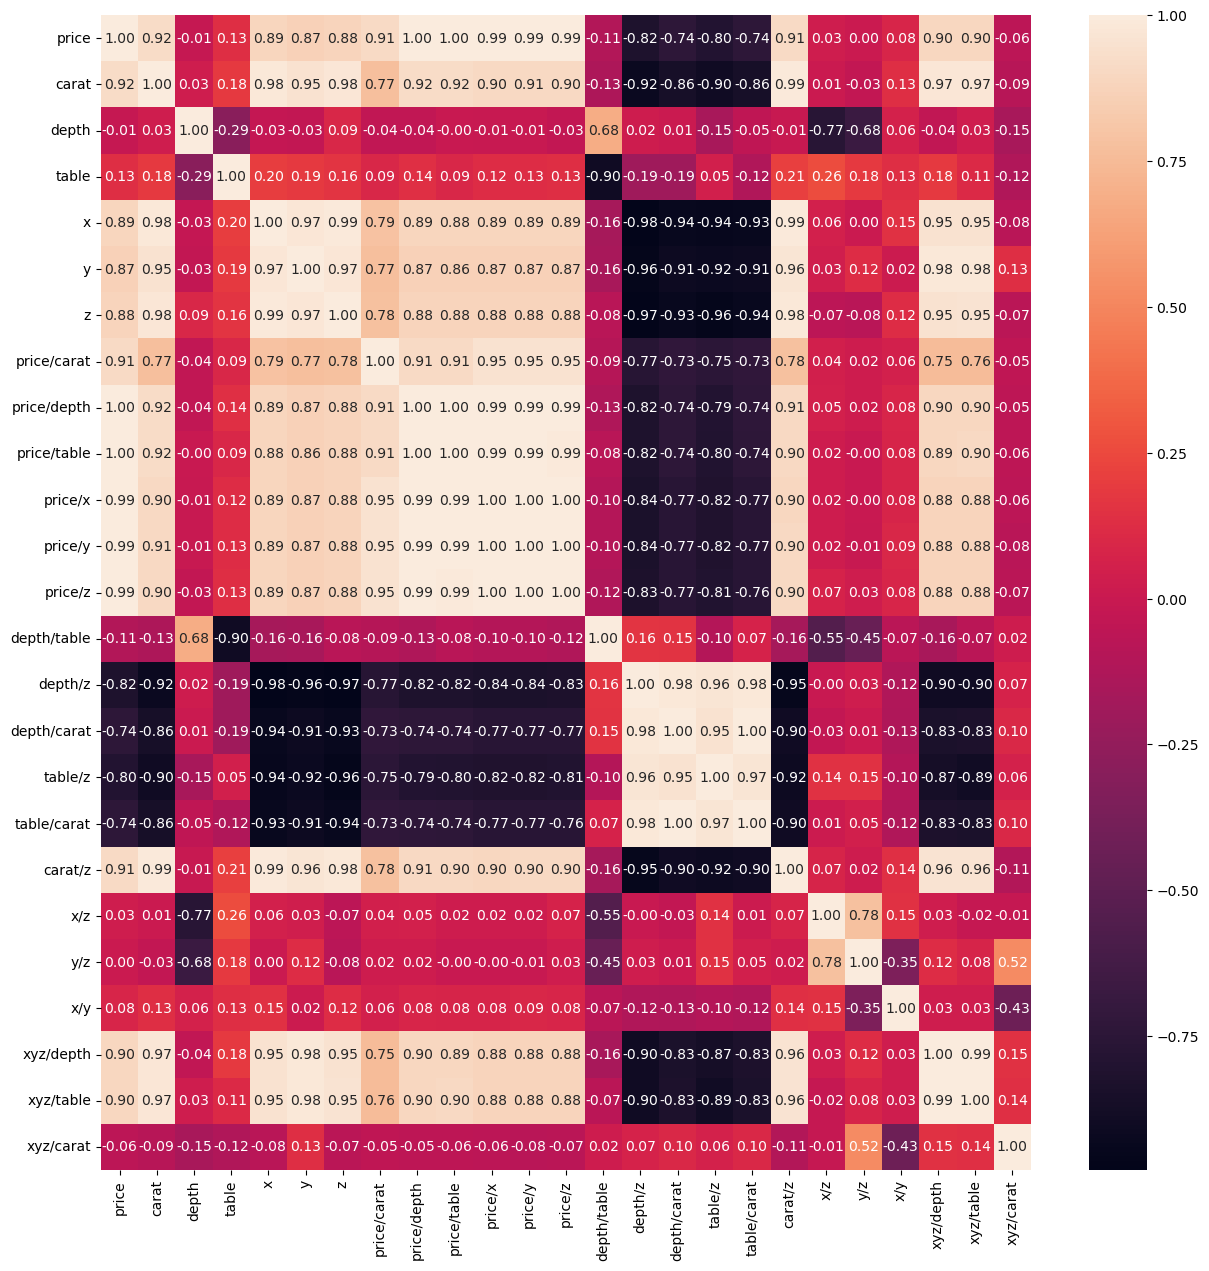

In [52]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1)
sns.heatmap(diamondsdf.corr(method='pearson'), annot=True, fmt='.2f', ax=ax);

# <font color='red'> DELETE THE ROW WITH Z = 58.90 ------------------------->
    
    table/y, table/x*z, table/x, depth/x, depth/y, depth/x*z, 
    
    table/(x+y+z)
    
    carat*depth
    
    x*y*z*table/carat*depth
    table + depth / carat

In [ ]:
diamondsdf.info()

## Statatistics of dataframe

In [ ]:
diamondsdf.describe()

### Correlations

In [ ]:
diamondsdf.corr()

### Median

In [ ]:
diamondsdf.median()

---

## Proportions of categorical columns

* Cut

In [ ]:
proportions_cut = diamondsdf['cut'].value_counts(normalize= True)
proportions_cut

* Plot of cut

In [ ]:
proportions_cut.plot.bar()

---

* Color

In [ ]:
proportions_color = diamondsdf['color'].value_counts(normalize= True)
proportions_color

* Plot of color

In [ ]:
proportions_color.plot.bar()

* Clarity

In [ ]:
proportions_clarity = diamondsdf['clarity'].value_counts(normalize= True)
proportions_clarity

* Plot of clarity

In [ ]:
proportions_clarity.plot.bar()

* City

In [ ]:
proportions_city = diamondsdf['city'].value_counts(normalize= True)
proportions_city

* Plot of city

In [ ]:
proportions_city.plot.bar()

---

## Color describe

In [ ]:
diamondsdf['color'].unique()

* Color J

In [ ]:
diamondsdfcolorJ = diamondsdf[diamondsdf['color'].str.contains('J')].sort_values(by = 'price', ascending = False)
diamondsdfcolorJ.describe()

* Color H

In [ ]:
diamondsdfcolorH = diamondsdf[diamondsdf['color'].str.contains('H')].sort_values(by = 'price', ascending = False)
diamondsdfcolorH.describe()

* Color D

In [ ]:
diamondsdfcolorD = diamondsdf[diamondsdf['color'].str.contains('D')].sort_values(by = 'price', ascending = False)
diamondsdfcolorD.describe()

* Color G

In [ ]:
diamondsdfcolorG = diamondsdf[diamondsdf['color'].str.contains('G')].sort_values(by = 'price', ascending = False)
diamondsdfcolorG.describe()

* Color F

In [ ]:
diamondsdfcolorF = diamondsdf[diamondsdf['color'].str.contains('F')].sort_values(by = 'price', ascending = False)
diamondsdfcolorF.describe()

* Color E

In [ ]:
diamondsdfcolorE = diamondsdf[diamondsdf['color'].str.contains('E')].sort_values(by = 'price', ascending = False)
diamondsdfcolorE.describe()

* Color I

In [ ]:
diamondsdfcolorI = diamondsdf[diamondsdf['color'].str.contains('I')].sort_values(by = 'price', ascending = False)
diamondsdfcolorI.describe()

---

## Clarity describe

In [ ]:
diamondsdf['clarity'].unique()

* Clarity VS2

In [ ]:
diamondsdf_clarity_VS2 = diamondsdf[diamondsdf['clarity'].str.contains('VS2')].sort_values(by = 'price', ascending = False)
diamondsdf_clarity_VS2.describe()

* Clarity VS1

In [ ]:
diamondsdf_clarity_VS1 = diamondsdf[diamondsdf['clarity'].str.contains('VS1')].sort_values(by = 'price', ascending = False)
diamondsdf_clarity_VS1.describe()

* Clarity SI1

In [ ]:
diamondsdf_clarity_SI1 = diamondsdf[diamondsdf['clarity'].str.contains('SI1')].sort_values(by = 'price', ascending = False)
diamondsdf_clarity_SI1.describe()

* Clarity IF

In [ ]:
diamondsdf_clarity_IF = diamondsdf[diamondsdf['clarity'].str.contains('IF')].sort_values(by = 'price', ascending = False)
diamondsdf_clarity_IF.describe()

* Clarity VVS1

In [ ]:
diamondsdf_clarity_VVS1 = diamondsdf[diamondsdf['clarity'].str.contains('VVS1')].sort_values(by = 'price', ascending = False)
diamondsdf_clarity_VVS1.describe()

* Clarity VVS2

In [ ]:
diamondsdf_clarity_VVS2 = diamondsdf[diamondsdf['clarity'].str.contains('VVS2')].sort_values(by = 'price', ascending = False)
diamondsdf_clarity_VVS2.describe()

* Clarity I1

In [ ]:
diamondsdf_clarity_I1 = diamondsdf[diamondsdf['clarity'].str.contains('I1')].sort_values(by = 'price', ascending = False)
diamondsdf_clarity_I1.describe()

---

## Cut describe

In [ ]:
diamondsdf['cut'].unique()

* Premiun

In [ ]:
diamondsdf_cut_Premium = diamondsdf[diamondsdf['cut'].str.contains('Premium')].sort_values(by = 'price', ascending = False)
diamondsdf_cut_Premium.describe()

* Very Good

In [ ]:
diamondsdf_cut_Very_Good = diamondsdf[diamondsdf['cut'].str.contains('Very Good')].sort_values(by = 'price', ascending = False)
diamondsdf_cut_Very_Good.describe()

* Fair

In [ ]:
diamondsdf_cut_Fair = diamondsdf[diamondsdf['cut'].str.contains('Fair')].sort_values(by = 'price', ascending = False)
diamondsdf_cut_Fair.describe()

* Good

In [ ]:
diamondsdf_cut_Good = diamondsdf[diamondsdf['cut'].str.contains('Good')].sort_values(by = 'price', ascending = False)
diamondsdf_cut_Good.describe()

* Ideal

In [ ]:
diamondsdf_cut_Ideal = diamondsdf[diamondsdf['cut'].str.contains('Ideal')].sort_values(by = 'price', ascending = False)
diamondsdf_cut_Ideal.describe()

---

## City describe

In [ ]:
diamondsdf['city'].unique()

* Dubai

In [ ]:
diamondsdf_city_Dubai = diamondsdf[diamondsdf['city'].str.contains('Dubai')].sort_values(by = 'price', ascending = False)
diamondsdf_city_Dubai.describe()

* Kimberly

In [ ]:
diamondsdf_city_Kimberly = diamondsdf[diamondsdf['city'].str.contains('Kimberly')].sort_values(by = 'price', ascending = False)
diamondsdf_city_Kimberly.describe()

* Las vegas

In [ ]:
diamondsdf_city_Las_Vegas = diamondsdf[diamondsdf['city'].str.contains('Las Vegas')].sort_values(by = 'price', ascending = False)
diamondsdf_city_Las_Vegas.describe()

* Tel Aviv

In [ ]:
diamondsdf_city_Tel_Aviv = diamondsdf[diamondsdf['city'].str.contains('Tel Aviv')].sort_values(by = 'price', ascending = False)
diamondsdf_city_Tel_Aviv.describe()

* Amsterdam

In [ ]:
diamondsdf_city_Amsterdam = diamondsdf[diamondsdf['city'].str.contains('Amsterdam')].sort_values(by = 'price', ascending = False)
diamondsdf_city_Amsterdam.describe()

* Zurich

In [ ]:
diamondsdf_city_Zurich = diamondsdf[diamondsdf['city'].str.contains('Zurich')].sort_values(by = 'price', ascending = False)
diamondsdf_city_Zurich.describe()

* Antwerp

In [ ]:
diamondsdf_city_Antwerp = diamondsdf[diamondsdf['city'].str.contains('Antwerp')].sort_values(by = 'price', ascending = False)
diamondsdf_city_Antwerp.describe()

* Madrid

In [ ]:
diamondsdf_city_Madrid = diamondsdf[diamondsdf['city'].str.contains('Madrid')].sort_values(by = 'price', ascending = False)
diamondsdf_city_Madrid.describe()

* Paris

In [ ]:
diamondsdf_city_Paris = diamondsdf[diamondsdf['city'].str.contains('Paris')].sort_values(by = 'price', ascending = False)
diamondsdf_city_Paris.describe()

* Surat

In [ ]:
diamondsdf_city_Surat = diamondsdf[diamondsdf['city'].str.contains('Surat')].sort_values(by = 'price', ascending = False)
diamondsdf_city_Surat.describe()

* Luxembourg

In [ ]:
diamondsdf_city_Luxembourg = diamondsdf[diamondsdf['city'].str.contains('Luxembourg')].sort_values(by = 'price', ascending = False)
diamondsdf_city_Luxembourg.describe()

* London

In [ ]:
diamondsdf_city_London = diamondsdf[diamondsdf['city'].str.contains('London')].sort_values(by = 'price', ascending = False)
diamondsdf_city_London.describe()

* New York City

In [ ]:
diamondsdf_city_New_York_City = diamondsdf[diamondsdf['city'].str.contains('New York City')].sort_values(by = 'price', ascending = False)
diamondsdf_city_New_York_City.describe()

---

### Pivot table

In [ ]:
diamondsdf_pivot_table = diamondsdf.pivot_table(index=['cut'],
                                                                           columns = 'city')
diamondsdf_pivot_table

<!-- ### Bin price/table -->